<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fraud Data

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import (cross_validate, cross_val_score, KFold,
                                      train_test_split, StratifiedKFold, 
                                       StratifiedShuffleSplit)
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from matplotlib.patches import Patch
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D

## Downloading data

In [3]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

! kaggle datasets download -d mlg-ulb/creditcardfraud

 64% 42.0M/66.0M [00:00<00:00, 35.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 84.8MB/s]


In [0]:
! unzip -q "creditcardfraud.zip"

In [0]:
df = pd.read_csv("creditcard.csv")

In [6]:
print('Fraud', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Not Fraud', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Fraud 0.17 % of the dataset
Not Fraud 99.83 % of the dataset


## Preprocessing

No columns need to be removed

In [18]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
norm = ((df - df.min())/(df.max()-df.min()))

In [8]:
norm.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
features = list(norm.columns[0:30])
print(features)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [0]:
x = norm[features]
y = norm['Class']

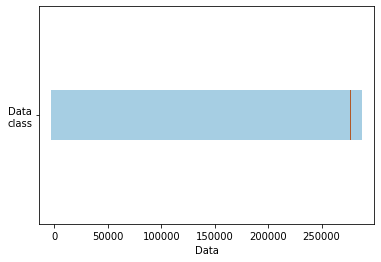

In [11]:
cmap_data = plt.cm.Paired
def visualize_classes(classes):
    fig, ax = plt.subplots()
    ax.scatter(range(len(classes)),  [3.5] * len(classes), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(yticks=[3.5],
           yticklabels=['Data\nclass'], xlabel="Data")


visualize_classes(y)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

**KFold Cross validation**

In [0]:
stnd = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(stnd, logit)
kf = KFold(n_splits = 10)

In [40]:
cv_results = cross_val_score(pipeline, x, y, cv=kf,scoring="accuracy", n_jobs=-1)
cv_results.mean()

0.9991467924703595

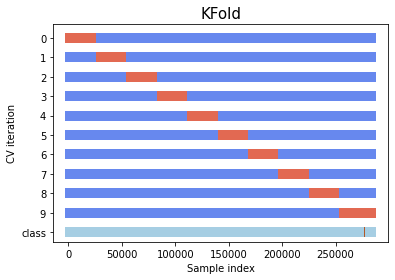

In [41]:
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)
    
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots()
plot_cv_indices(kf, x, y, ax, 10)

## Classifiers and Cross Validation

**Dummy Classifier**

In [42]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(x_train, y_train)
dummy.score(x_test, y_test)  

0.5002247127889666

**Decision Tree**

In [43]:
dt = DecisionTreeClassifier(min_samples_split = 30, max_depth = 4, random_state = 32)
dt.fit(x_train, y_train)
print("DT score: ", dt.score(x_test, y_test))
print("Train score: ", cross_validate(dt, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(dt, x_test, y_test)['test_score'].mean())

DT score:  0.9994241734782731
Train score:  0.9993118138620349
Test score:  0.9992415947308334


Feature Importances 

> Only 7 features have non-zero importance

Feature ranking:
1. V17 (0.736503)
2. V10 (0.095296)
3. V14 (0.088127)
4. V27 (0.030293)
5. V26 (0.027593)
6. V21 (0.010449)
7. V3 (0.006780)
8. V12 (0.004958)
9. V4 (0.000000)
10. V5 (0.000000)
11. V6 (0.000000)
12. V7 (0.000000)
13. V2 (0.000000)
14. V8 (0.000000)
15. V9 (0.000000)
16. V1 (0.000000)
17. V11 (0.000000)
18. Amount (0.000000)
19. V13 (0.000000)
20. V28 (0.000000)
21. V15 (0.000000)
22. V16 (0.000000)
23. V18 (0.000000)
24. V19 (0.000000)
25. V20 (0.000000)
26. V22 (0.000000)
27. V23 (0.000000)
28. V24 (0.000000)
29. V25 (0.000000)
30. Time (0.000000)


(0.0, 0.7733280314371411)

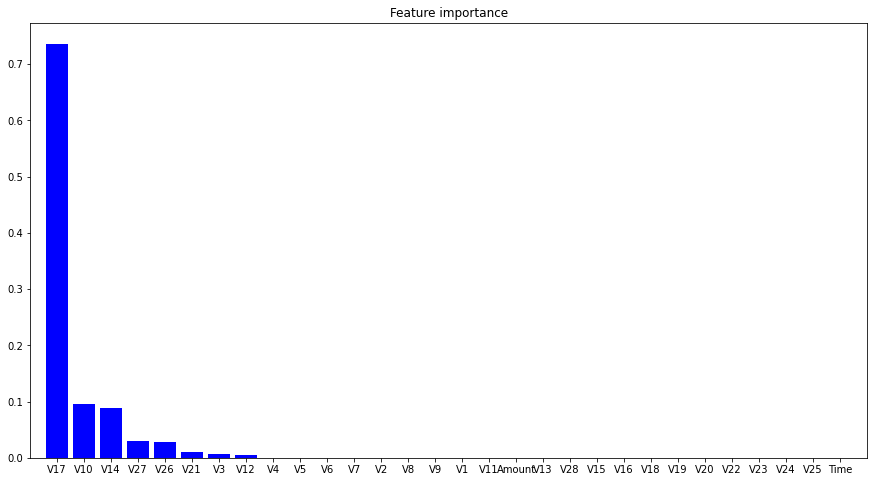

In [44]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Random Tree**

In [45]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf.fit(x_train, y_train)
print("DT score: ", rf.score(x_test, y_test))
print("Train score: ", cross_validate(rf, x_train, y_train)['test_score'].mean())
print("Test score: ", cross_validate(rf, x_test, y_test)['test_score'].mean())

DT score:  0.9993820398303418
Train score:  0.9993445846305097
Test score:  0.9993118174774687


Feature importances

> All features have non-zero importance

Feature ranking:
1. V17 (0.228202)
2. V12 (0.163312)
3. V10 (0.108611)
4. V14 (0.107333)
5. V11 (0.093179)
6. V16 (0.090110)
7. V9 (0.031262)
8. V18 (0.029610)
9. V4 (0.027327)
10. V7 (0.025612)
11. V3 (0.014324)
12. V21 (0.011524)
13. V26 (0.008823)
14. V6 (0.007940)
15. V27 (0.006996)
16. V5 (0.006880)
17. V1 (0.005371)
18. V8 (0.005137)
19. V28 (0.004474)
20. V20 (0.003909)
21. V2 (0.003584)
22. V24 (0.003106)
23. V15 (0.002792)
24. V19 (0.002661)
25. Time (0.001839)
26. Amount (0.001716)
27. V25 (0.001356)
28. V22 (0.001319)
29. V23 (0.001189)
30. V13 (0.000501)


(0.0, 0.5703456077606524)

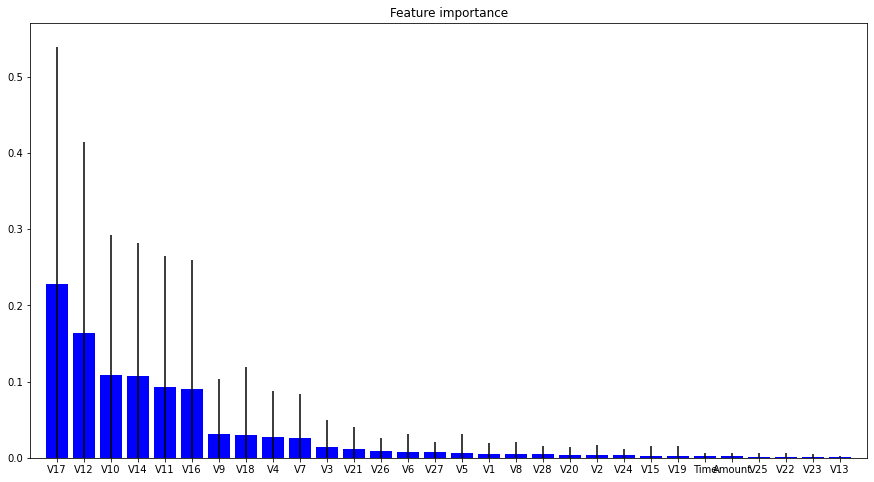

In [46]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(x.shape[1]):
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

fig = plt.figure()
plt.title("Feature importance")
plt.bar(range(x.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), np.array(features)[indices])
plt.xlim([-1, x.shape[1]])
fig.set_size_inches(15, 8)
axes = plt.gca()
axes.set_ylim([0, None])

**Decision Tree Regressor**

In [47]:
tr = DecisionTreeRegressor(random_state = 0, max_depth = 4, min_samples_split= 30)
tr.fit(x_train, y_train)
print("Test score: ", tr.score(x_test, y_test))
print("CrossVal score: ", cross_validate(tr, x_test, y_test, cv = 10)['test_score'].mean())

Test score:  0.6884789921708029
CrossVal score:  0.6193094683733845


**KFold Cross validation**

In [0]:
stnd = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(stnd, logit)
kf = KFold(n_splits = 5)

In [49]:
cv_results = cross_val_score(pipeline, x, y, cv=kf,scoring="accuracy", n_jobs=-1)
cv_results.mean()

0.9991503030900317

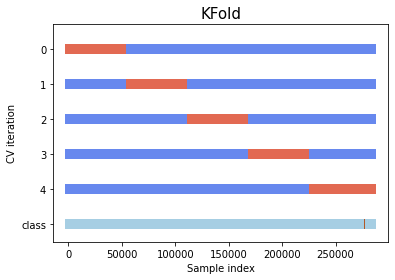

In [50]:
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)
    
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots()
plot_cv_indices(kf, x, y, ax, 5)

## Stratified KFold

In [0]:
skf = StratifiedKFold(n_splits=5)

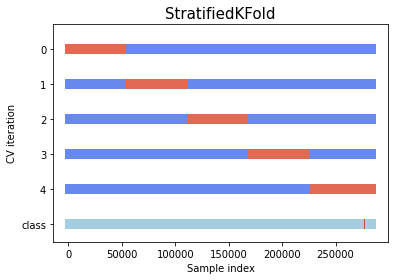

In [52]:
def plot_scv_indices(cv, X, y, ax, n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

fig, ax = plt.subplots()
plot_scv_indices(skf, x, y, ax, 5)

Split data into 4/5 and 5/5

In [0]:
i = 0
X = x.values
Y = y.values
for train_index, test_index in skf.split(X, Y):
    if i < 4:
      X_train_4, X_test_4 = X[train_index], X[test_index]
      y_train_4, y_test_4 = Y[train_index], Y[test_index]
      i = i + 1
    else:
      X_train_5 , X_test_5 = X[train_index], X[test_index] 
      y_train_5, y_test_5 = Y[train_index], Y[test_index]

X4 = X_train_4
X4t = X_test_4
Y4 = y_train_4
Y4t = y_test_4

X5 = X_train_5
X5t = X_test_5
Y5= y_train_5
Y5t = y_test_5

For n_clusters = 2 The average silhouette_score is : 0.43744928977021047
For n_clusters = 3 The average silhouette_score is : 0.23252259299344047
For n_clusters = 4 The average silhouette_score is : 0.1899937048490557
For n_clusters = 5 The average silhouette_score is : 0.17688863977495264
For n_clusters = 6 The average silhouette_score is : 0.17288558204577223


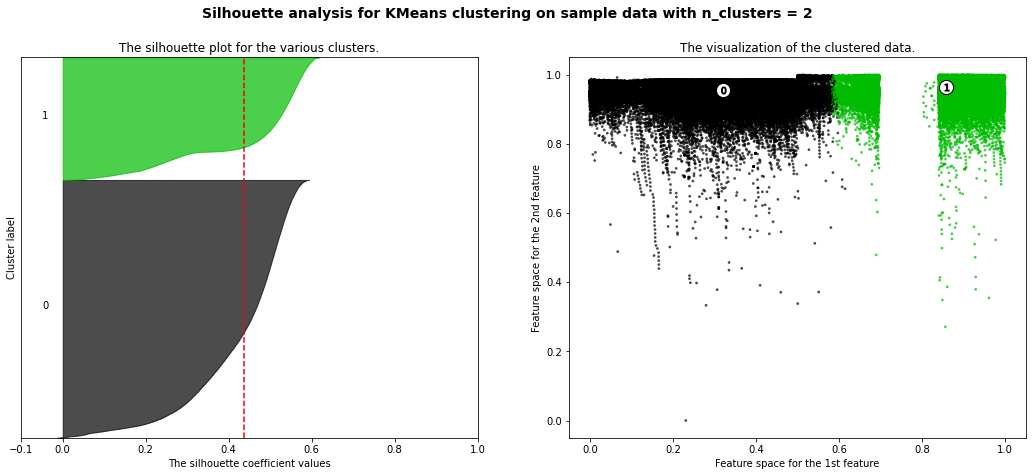

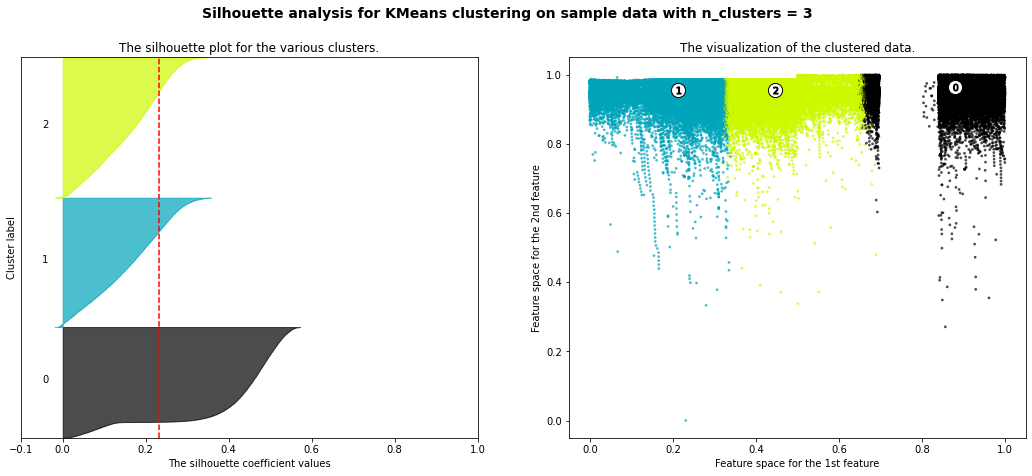

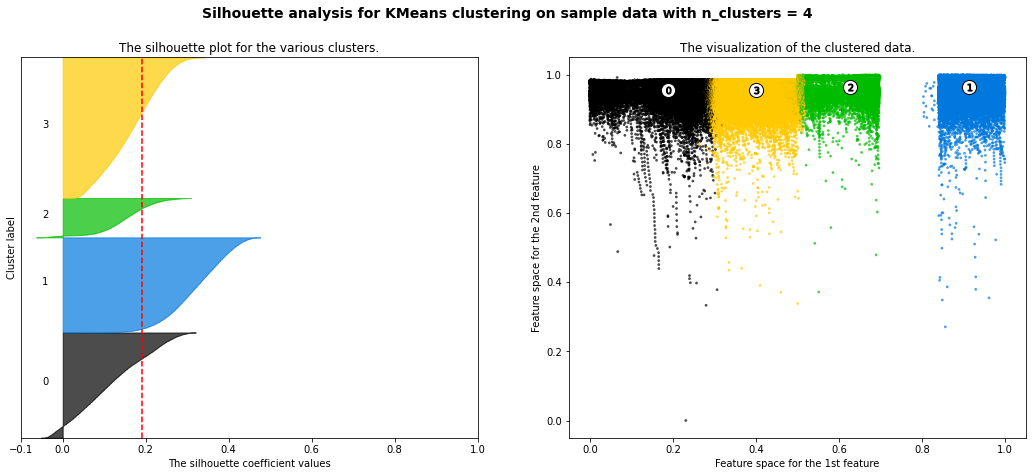

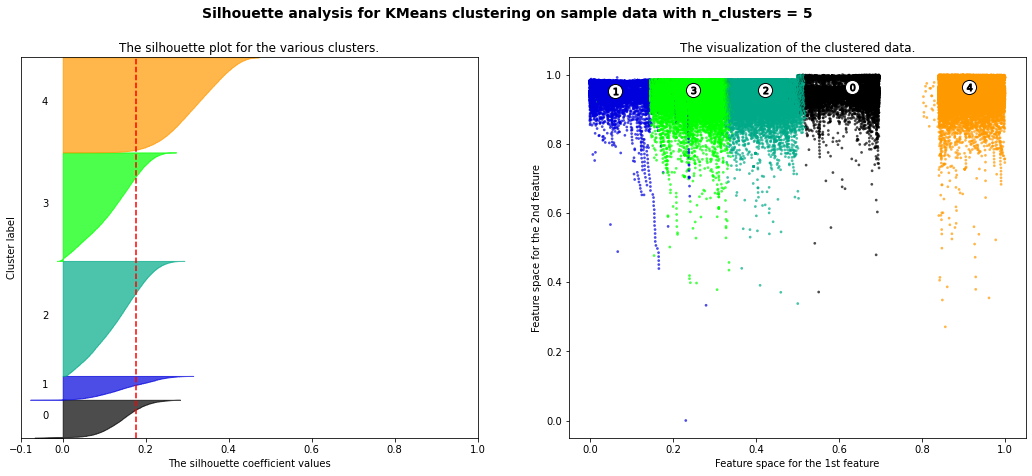

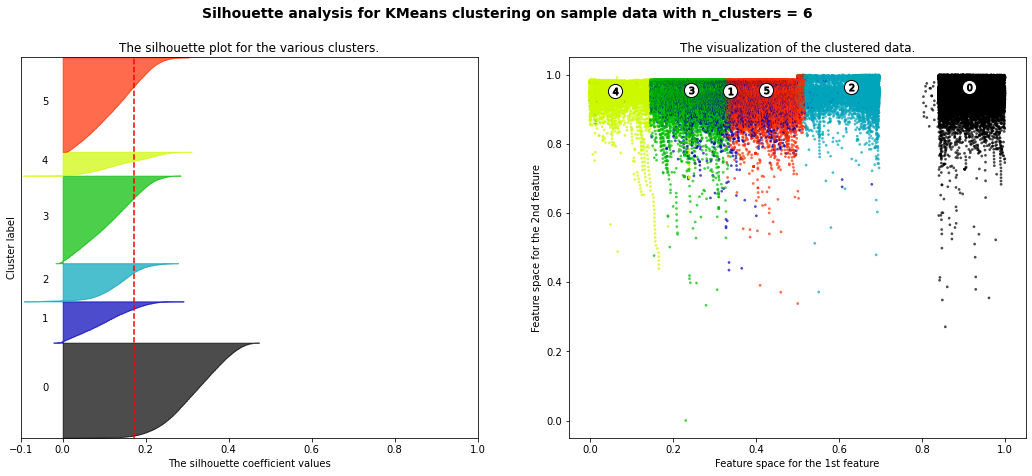

In [56]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X4) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X4)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X4, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X4, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X4[:, 0], X4[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Elbow**

In [0]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X4)
    Sum_of_squared_distances.append(km.inertia_)

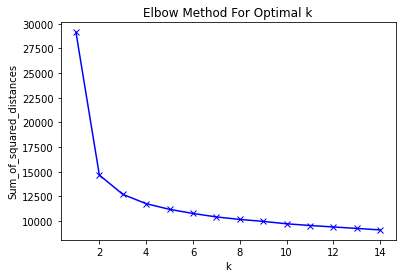

In [53]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Clustering

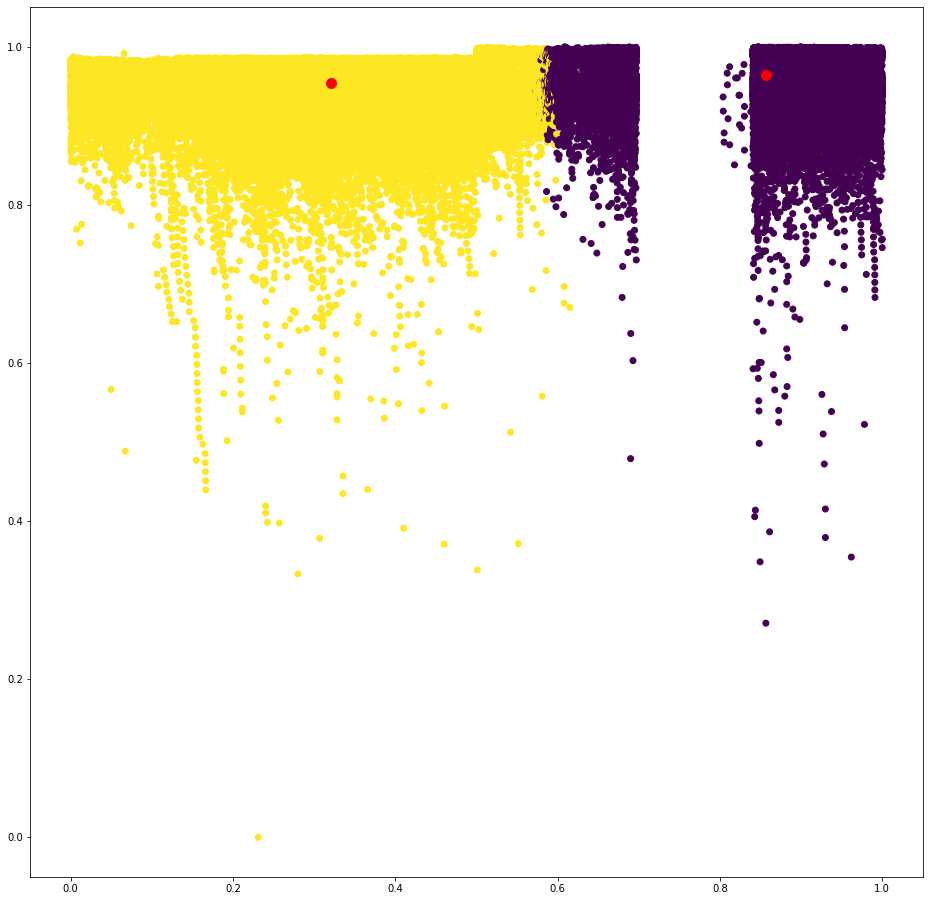

In [54]:
plt.figure(figsize=(16, 16))

km = KMeans(n_clusters=2).fit(X4)
centres = km.cluster_centers_

kmp = km.fit_predict(X4)
plt.scatter(X4[:, 0], X4[:, 1], c=kmp)
plt.scatter(centres[:,0], centres[:,1], c='red', s=100)

plt.show()

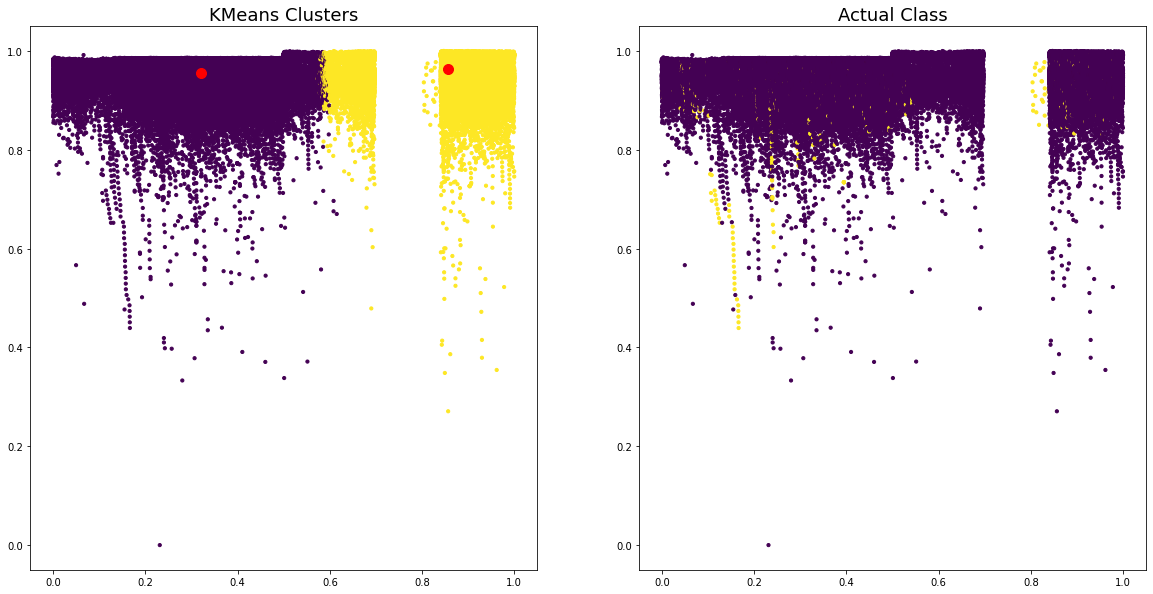

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

km = KMeans(n_clusters=2).fit(X4)
centres = km.cluster_centers_
kmp = km.fit_predict(X4)
labels = km.labels_

ax1.scatter(X4[:, 0], X4[:, 1], c=kmp, s= 10)
ax1.scatter(centres[:,0], centres[:,1], c='red', s=100)
ax1.set_title("KMeans Clusters", fontsize = 18)

ax2.scatter(X4[:, 0], X4[:, 1], c=Y4, alpha = 100, s = 10)
ax2.set_title("Actual Class", fontsize = 18)


fig.show()

There is no obvious way to cluster the data

> Shown in 3D, the actual clusters are shown 

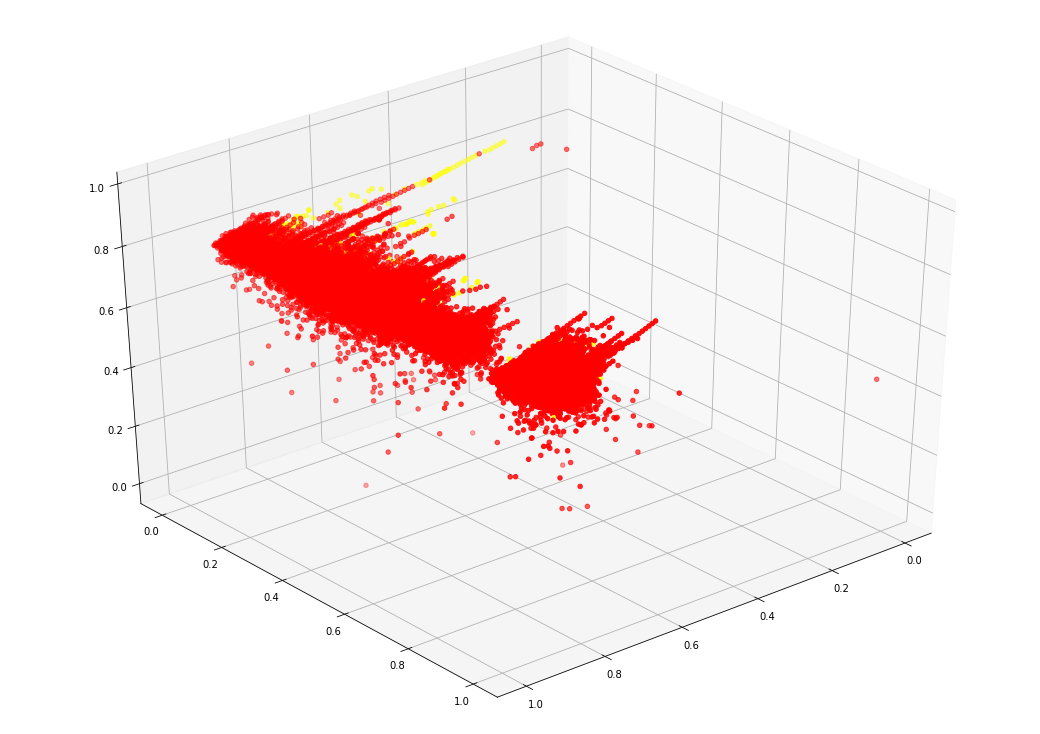

In [60]:
fig = plt.figure(1, figsize=(4, 3))
fig.set_size_inches(15, 10)

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=35, azim=50)
ax.scatter(X4[:, 3], X4[:, 0], X4[:, 2], c=Y4, cmap=plt.cm.autumn)

fig.show()

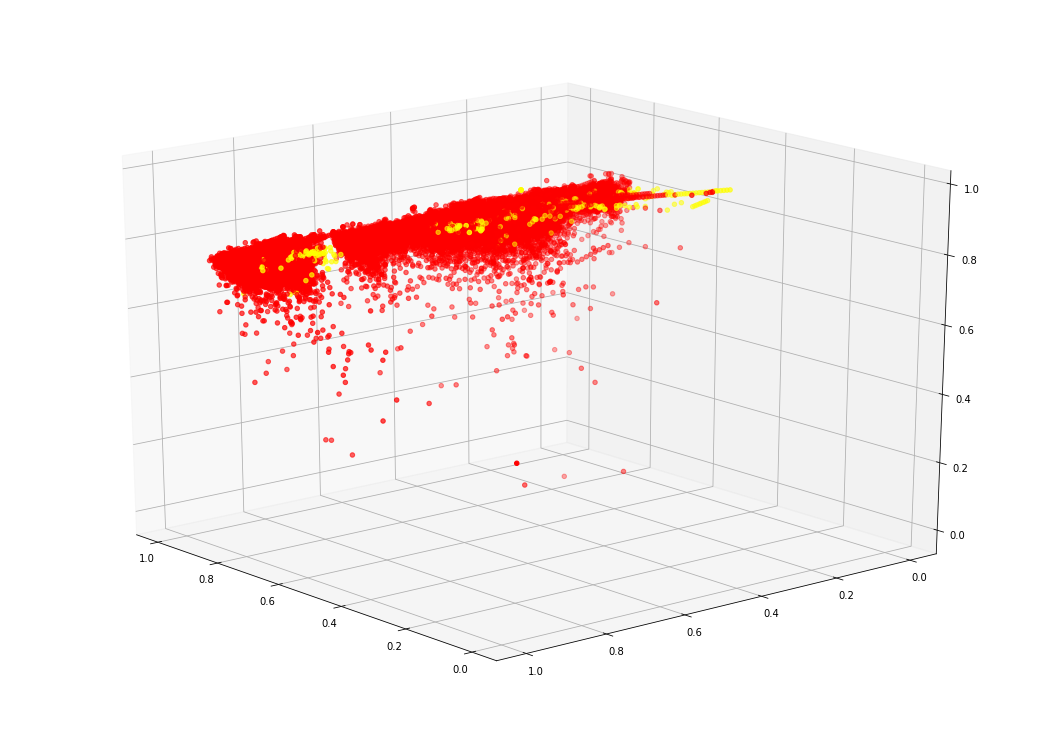

In [51]:
fig = plt.figure(1, figsize=(4, 3))
fig.set_size_inches(15, 10)

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=140)
ax.scatter(X4[:, 3], X4[:, 0], X4[:, 2], c=Y4, cmap=plt.cm.autumn)

## Random Forest

In [0]:
d = {'class': Y4, 'label':labels}
f = pd.DataFrame(d, dtype=int)
f['correct'] = np.where(f['class'] == f['label'], 'yes', 'no')

In [67]:
unique, counts = np.unique(f['correct'], return_counts=True)
dict(zip(unique, counts))

{'no': 73636, 'yes': 154210}

In [0]:
cluster_1 = f['label'] == 0
cluster_2 = f['label'] == 1

In [0]:
C1 = f[cluster_1]
C2 = f[cluster_2]

In [71]:
print('Cluster1 is', round(C1['class'].value_counts()[1]/len(C1) * 100,2), "% class 1, ",
      round(C1['class'].value_counts()[0]/len(C1) * 100,2), "% class 2.")
print('Cluster2 is', round(C2['class'].value_counts()[1]/len(C2) * 100,2), "% class 1, ",
      round(C2['class'].value_counts()[0]/len(C2) * 100,2), "% class 2.")

Cluster1 is 0.19 % class 1,  99.81 % class 2.
Cluster2 is 0.13 % class 1,  99.87 % class 2.


In [0]:
d = pd.DataFrame(X4)
d['label']=labels
d['target']=Y4

In [0]:
cluster_1_data = d['label'] == 0
cluster_2_data = d['label'] == 1

In [0]:
C1d = d[cluster_1_data]
C2d = d[cluster_2_data]

In [0]:
C1d = C1d.drop(['label'], axis = 1)
C2d = C2d.drop(['label'], axis = 1)

In [0]:
C1d_target = C1d['target']
C1d = C1d.drop(['target'], axis = 1)

C2d_target = C2d['target']
C2d = C2d.drop(['target'], axis = 1)

In [77]:
rf_cluster1 = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf_cluster1.fit(C1d, C1d_target)
print("Test score: ", rf_cluster1.score(X4t, Y4t))
print("CrossVal score: ", cross_validate(rf_cluster1, X4t, Y4t, cv = 10)['test_score'].mean())

Test score:  0.9994031003669177
CrossVal score:  0.9996313233063727


In [78]:
rf_cluster2 = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 32)
rf_cluster2.fit(C2d, C2d_target)
print("Test score: ", rf_cluster2.score(X4t, Y4t))
print("CrossVal score: ", cross_validate(rf_cluster2, X4t, Y4t, cv = 10)['test_score'].mean())

Test score:  0.9995611032109689
CrossVal score:  0.9996313233063727


## X5

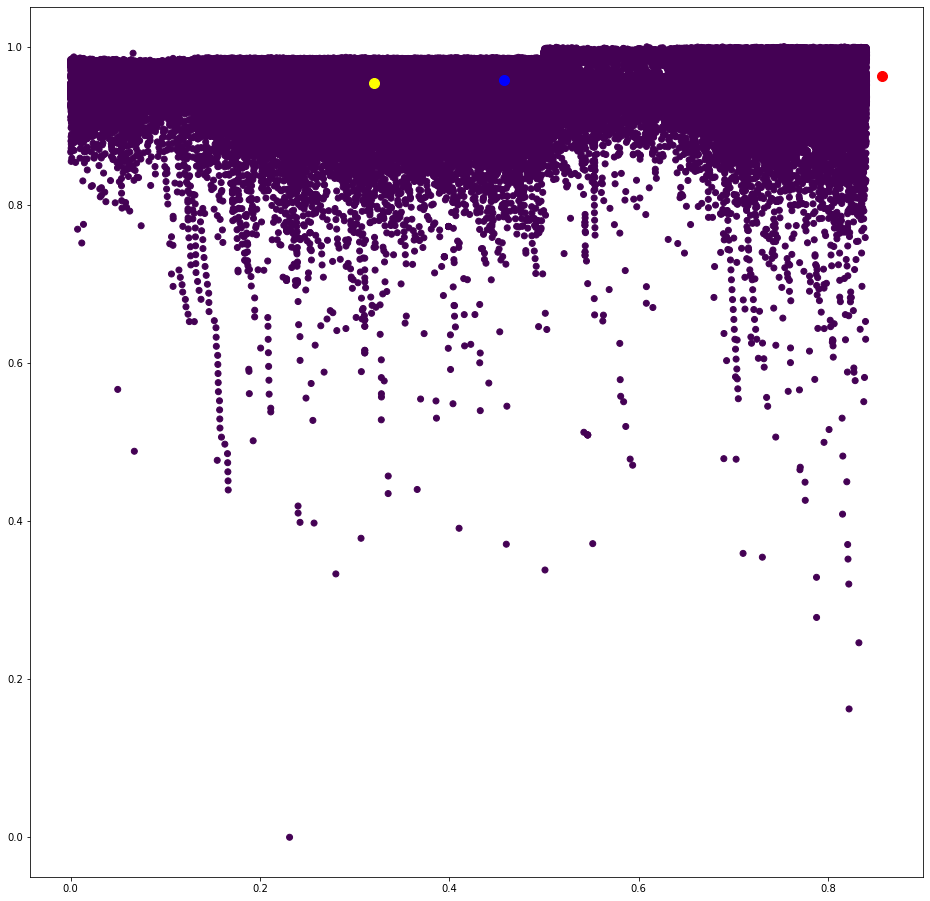

In [80]:
plt.figure(figsize=(16, 16))

km = KMeans(n_clusters=1).fit(X5)
centres_5 = km.cluster_centers_
labels_5 =  km.labels_
kmp = km.fit_predict(X5)

#cluster 1 centre
c1x = centres[0,0]
c1y = centres[0,1]

#cluster 2 centre
c2x = centres[1,0]
c2y = centres[1,1]

plt.scatter(X5[:, 0], X5[:, 1], c=kmp)
plt.scatter(centres_5[:,0], centres_5[:,1], c='blue', s=100)
plt.scatter(c1x, c1y, c='yellow', s=100)
plt.scatter(c2x, c2y, c='red', s=100)

plt.show()

Cluster centre of X5 is closest to cluster 1 (yellow)

In [81]:
print("Test score: ", rf_cluster1.score(X5, Y5))
print("CrossVal score: ", cross_validate(rf_cluster1, X5, Y5, cv = 10)['test_score'].mean())

Test score:  0.999468939546887
CrossVal score:  0.9992319371682162


In [82]:
print("Test score: ", rf_cluster1.score(X5t, Y5t))
print("CrossVal score: ", cross_validate(rf_cluster1, X5t, Y5t, cv = 10)['test_score'].mean())

Test score:  0.9991397622934991
CrossVal score:  0.9993504336749286
